# Steady-state BVP from heat conduction

Consider solving
$$
 \begin{cases}-\kappa u_{xx}(x) = g(x),\\
 u(0) = 0,\\
 u(1) = 0.\end{cases}
$$

In [1]:
using LinearAlgebra, Plots, LaTeXStrings

In [2]:
m = 49; # number of interior grid points
h = 1/(m+1); # grid spacing
κ = 1.0;
xs = h:h:1-h

0.02:0.02:0.98

In [3]:
A = SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
L = A/h^2;

A solution to compare against.  Consider $u(x) = \sin(k \pi x) \exp(-x^2)$.  Then it follows that

\begin{align*}
    -u_{xx}(x) = g(x), \quad g(x) = \left[ k^2 \pi^2 \sin(k \pi x) + 4 x k \pi \cos(k \pi x) + ( 2 - 4x^2 ) \sin(k \pi x) \right] \exp(-x^2).
\end{align*}

In [43]:
k = 1
g = x -> exp(-x^2)*(k^2*pi^2*sin(k*pi*x) + 4*x*k*pi*cos(k*pi*x) + (2 - 4*x^2)*sin(k*pi*x))
u = x -> sin(k*pi*x)*exp(-x^2)

#69 (generic function with 1 method)

In [44]:
b = map(g,xs)
U = L\b
utrue = map(u,xs);

In [45]:
maximum(abs.(U-utrue))

0.00041278608790606963

## Setup function to test convergence

In [46]:
function solve_DE(m)
    h = 1/(m+1); # grid spacing
    κ = 1.0;
    xs = h:h:1-h
    A = SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
    L = A/h^2;
    b = map(g,xs)
    U = L\b
    utrue = map(u,xs)
    maximum(abs.(U-utrue))
end

solve_DE (generic function with 1 method)

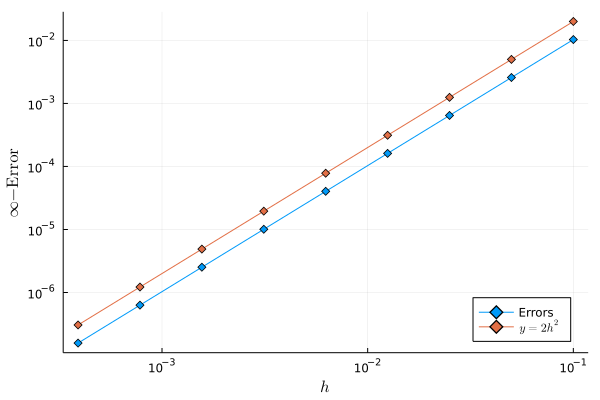

In [8]:
m = 10;
errs = [solve_DE(m*2^j-1) for j = 0:1:8]
hs = [1/(m*2^j) for j = 0:1:8]
plot(hs,errs,yaxis=:log,xaxis=:log,label="Errors",markershape=:diamond,legend =:bottomright)
plot!(hs,2hs.^2,label=L"y = 2h^2",xlabel = L"h",ylabel = L"\infty\mathrm{-Error}",markershape=:diamond)
    

## Smoothness of solutions

Consider $u(x) = x(x-1) |x-1/2|^2 \mathrm{sgn}(x-1/2)$.  Then

\begin{align*}
    -u_{xx}(x) = g(x), \quad g(x) = 
    \begin{cases}
        \frac{5}{2} - 12 x + 12 x^2 & x > 1/2,\\
        -\frac{5}{2} + 12 x - 12 x^2 & x \leq 1/2.
    \end{cases}
\end{align*}

In [47]:
k = 1
p = x -> 5/2 - 12*x + 12*x^2
g = x -> x > 1/2 ? -p(x) : p(x)
u = x -> x*(x-1)*abs(x-0.5)^2*sign(x-0.5)

#75 (generic function with 1 method)

In [48]:
function solve_DE(m)
    h = 1/(m+1); # grid spacing
    κ = 1.0;
    xs = h:h:1-h
    A = SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
    L = A/h^2;
    b = map(g,xs)
    U = L\b
    utrue = map(u,xs)
    maximum(abs.(U-utrue))
end

solve_DE (generic function with 1 method)

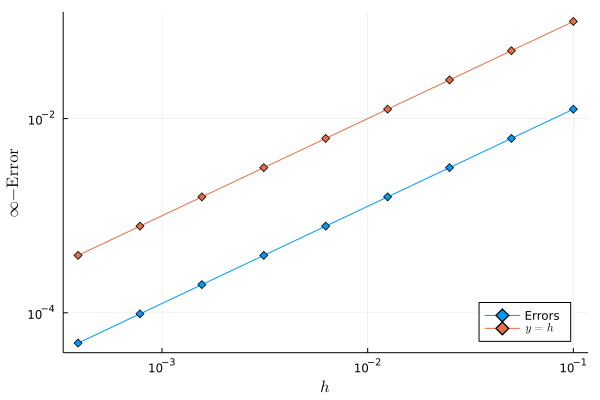

In [50]:
m = 10;
errs = [solve_DE(m*2^j-1) for j = 0:1:8]
hs = [1/(m*2^j) for j = 0:1:8]
plot(hs,errs,yaxis=:log,xaxis=:log,label="Errors",markershape=:diamond,legend =:bottomright)
plot!(hs,hs,label=L"y = h",xlabel = L"h",ylabel = L"\infty\mathrm{-Error}",markershape=:diamond)
    

# Higher-order methods

In [51]:
using FiniteDifferences, SparseArrays

In [62]:
method = FiniteDifferenceMethod([-1, 0, 1], 2)
display(method)
interior = method.coefs |> Vector;

FiniteDifferenceMethod:
  order of method:       3
  order of derivative:   2
  grid:                  [-1, 0, 1]
  coefficients:          [1.0, -2.0, 1.0]


In [63]:
method = FiniteDifferenceMethod([-2,-1, 0, 1,2], 2)
display(method)
interior = method.coefs |> Vector;

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   2
  grid:                  [-2, -1, 0, 1, 2]
  coefficients:          [-0.08333333333333333, 1.3333333333333333, -2.5, 1.3333333333333333, -0.08333333333333333]


In [64]:
method = FiniteDifferenceMethod([-1,0,1,2,3], 2)
display(method)
left = method.coefs |> Vector;

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   2
  grid:                  [-1, 0, 1, 2, 3]
  coefficients:          [0.9166666666666666, -1.6666666666666667, 0.5, 0.3333333333333333, -0.08333333333333333]


In [65]:
method = FiniteDifferenceMethod([-3,-2,-1,0,1], 2)
display(method)
right = method.coefs |> Vector;

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   2
  grid:                  [-3, -2, -1, 0, 1]
  coefficients:          [-0.08333333333333333, 0.3333333333333333, 0.5, -1.6666666666666667, 0.9166666666666666]


In [66]:
m = 49; # number of interior grid points
h = 1/(m+1); # grid spacing
κ = 1.0;
xs = h:h:1-h

0.02:0.02:0.98

In [68]:
L = spzeros(m,m);
L[1,1:4] = left[2:end]
L[2,1:4] = interior[2:end]
L[end,end-3:end] = right[1:end-1]
L[end-1,end-3:end] = interior[1:end-1]
for i = 3:m-2
    L[i,i-2:i+2] = interior
end
L[1:5,1:5] |> Array |> display
L *= -κ/h^2

5×5 Matrix{Float64}:
 -1.66667     0.5         0.333333   -0.0833333   0.0
  1.33333    -2.5         1.33333    -0.0833333   0.0
 -0.0833333   1.33333    -2.5         1.33333    -0.0833333
  0.0        -0.0833333   1.33333    -2.5         1.33333
  0.0         0.0        -0.0833333   1.33333    -2.5

49×49 SparseMatrixCSC{Float64, Int64} with 241 stored entries:
⢿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⡄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠁

In [69]:
k = 1
g = x -> exp(-x^2)*(k^2*pi^2*sin(k*pi*x) + 4*x*k*pi*cos(k*pi*x) + (2 - 4*x^2)*sin(k*pi*x))
u = x -> sin(k*pi*x)*exp(-x^2)

#87 (generic function with 1 method)

In [70]:
b = map(g,xs)
U = L\b
utrue = map(u,xs);

In [71]:
U - utrue

49-element Vector{Float64}:
 -2.8802498648616837e-7
 -2.6107595302304887e-7
 -2.1236757113962668e-7
 -1.6334847746657388e-7
 -1.1593848425750508e-7
 -7.063332546630718e-8
 -2.779979108025188e-8
  1.2235598978449502e-8
  4.9184058492635074e-8
  8.279764762697539e-8
  1.1287220336164694e-7
  1.3924963770950427e-7
  1.6181954032301604e-7
  ⋮
 -4.089474686663763e-8
 -4.6188765756571826e-8
 -4.9085176978547196e-8
 -4.951939180930509e-8
 -4.746006024292093e-8
 -4.290804264672765e-8
 -3.5894960948024135e-8
 -2.6481435044800605e-8
 -1.475587986521365e-8
 -8.45500669477417e-10
  1.4899062143747255e-8
  2.9297356651802886e-8

In [72]:
function solve_DE_HO(m)
    h = 1/(m+1); # grid spacing
    κ = 1.0;
    xs = h:h:1-h
    
    L = spzeros(m,m);
    L[1,1:4] = left[2:end]
    L[2,1:4] = interior[2:end]
    L[end,end-3:end] = right[1:end-1]
    L[end-1,end-3:end] = interior[1:end-1]
    for i = 3:m-2
        L[i,i-2:i+2] = interior
    end
    L *= -κ/h^2
    b = map(g,xs)
    U = L\b
    utrue = map(u,xs)
    maximum(abs.(U-utrue))
end

solve_DE_HO (generic function with 1 method)

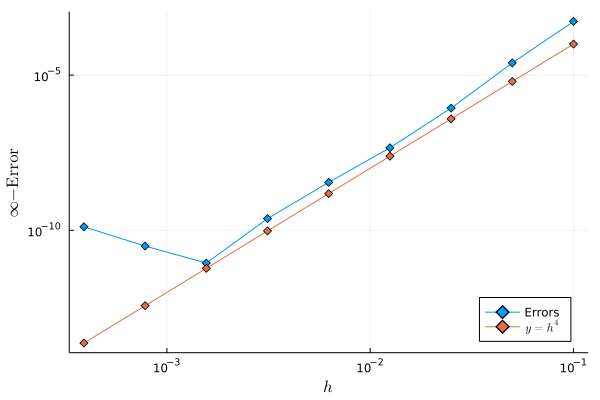

In [73]:
m = 10;
errs = [solve_DE_HO(m*2^j-1) for j = 0:1:8]
hs = [1/(m*2^j) for j = 0:1:8]
plot(hs,errs,yaxis=:log,xaxis=:log,label="Errors",markershape=:diamond,legend =:bottomright)
plot!(hs,hs.^4,label=L"y = h^4",xlabel = L"h",ylabel = L"\infty\mathrm{-Error}",markershape=:diamond)